### Monocular Visual Odometry using Epipolar Constraint

This code is adopted from https://github.com/mint-lab/3dv_tutorial 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
def set_axes_equal(ax):
    """Set 3D plot axes to equal scale so spheres look like spheres."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim3d([mid_x - max_range, mid_x + max_range])
    ax.set_ylim3d([mid_y - max_range, mid_y + max_range])
    ax.set_zlim3d([mid_z - max_range, mid_z + max_range])

In [3]:
# path to data and algorithm parameters
video_file = 'data/KITTI07/image_0/%06d.png'
f, cx, cy = 707.0912, 601.8873, 183.1104
use_essential = True  # use essential matrix, otherwise use fundamental matrix
min_inlier_num = 50
min_inlier_ratio = 0.1
traj_file = 'vo_epipolar_results.xyz'

/tmp/ipykernel_5234/2924548787.py:60: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  traj_axes.set_xlim(min(camera_traj[:,0]), max(camera_traj[:,0]))
/tmp/ipykernel_5234/2924548787.py:61: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  traj_axes.set_ylim(min(camera_traj[:,1]), max(camera_traj[:,1]))
/tmp/ipykernel_5234/2924548787.py:62: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  traj_axes.set_zlim(min(camera_traj[:,2]), max(camera_traj[:,2]))
QObject::moveToThread: Current thread (0x559ff4bdd660) is not the object's thread (0x559ff5447110).
Cannot move to target thread (0x559ff4bdd660)

QObject::moveToThread: Current thread (0x559ff4bdd660) is not the object's thread (0x559ff5447110).
Cannot move to target thread (0x559ff4bdd660)

QObject::moveToThre

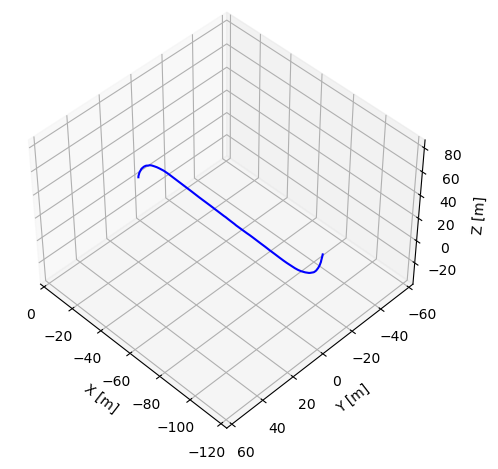

In [4]:
# Open a video and get an initial image
video = cv.VideoCapture(video_file)
assert video.isOpened()

_, gray_prev = video.read()
assert gray_prev.size > 0
if gray_prev.ndim >= 3 and gray_prev.shape[2] > 1:
    gray_prev = cv.cvtColor(gray_prev, cv.COLOR_BGR2GRAY)

# Prepare a plot to visualize the camera trajectory
plt.ion()
traj_axes = plt.figure(layout='tight').add_subplot(projection='3d')
traj_axes.set_xlabel('X [m]')
traj_axes.set_ylabel('Y [m]')
traj_axes.set_zlabel('Z [m]')
traj_axes.grid(True)
traj_axes.view_init(azim=-90)
traj_line, = plt.plot([], [], [], 'b-')

# Run monocular visual odometry
K = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])
camera_pose = np.eye(4)
camera_traj = np.zeros((1, 3))
while True:
    # Grab an image from the video
    valid, img = video.read()
    if not valid:
        break
    if img.ndim >= 3 and img.shape[2] > 1:
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # Extract optical flow
    pts_prev = cv.goodFeaturesToTrack(gray_prev, 2000, 0.01, 10)
    pts, status, error = cv.calcOpticalFlowPyrLK(gray_prev, gray, pts_prev, None)
    gray_prev = gray

    # Calculate relative pose
    if use_essential:
        E, inlier_mask = cv.findEssentialMat(pts_prev, pts, f, (cx, cy), cv.FM_RANSAC, 0.99, 1)
    else:
        F, inlier_mask = cv.findFundamentalMat(pts_prev, pts, cv.FM_RANSAC, 1, 0.99)
        E = K.T @ F @ K
    inlier_num, R, t, inlier_mask = cv.recoverPose(E, pts_prev, pts, focal=f, pp=(cx, cy), mask=inlier_mask)
    inlier_ratio = inlier_num / len(pts)

    # Accumulate relative pose if result is reliable
    info_color = (0, 255, 0)
    if inlier_num > min_inlier_num and inlier_ratio > min_inlier_ratio:
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t.flatten()
        camera_pose = camera_pose @ np.linalg.inv(T)
        info_color = (0, 0, 255)

    # Show the camera trajectory interactively
    x, y, z = camera_pose[:3, 3]
    camera_traj = np.vstack((camera_traj, [x, y, z]))
    traj_axes.set_xlim(min(camera_traj[:,0]), max(camera_traj[:,0]))
    traj_axes.set_ylim(min(camera_traj[:,1]), max(camera_traj[:,1]))
    traj_axes.set_zlim(min(camera_traj[:,2]), max(camera_traj[:,2]))
    # traj_axes.set_aspect('auto')
    set_axes_equal(traj_axes)
    traj_axes.view_init(elev=45, azim=135)
    traj_line.set_data_3d(camera_traj[:,0], camera_traj[:,1], camera_traj[:,2])
    plt.draw()

    # Show the image and write camera pose
    if img.ndim < 3 or img.shape[2] < 3:
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    for pt, pt_prev, inlier in zip(pts, pts_prev, inlier_mask):
        color = (0, 255, 0) if inlier else (0, 0, 127)
        cv.line(img, pt_prev.flatten().astype(np.int32), pt.flatten().astype(np.int32), color)
    info = f'Inliers: {inlier_num} ({inlier_ratio*100:.0f}%), XYZ: [{x:.3f} {y:.3f} {z:.3f}]'
    cv.putText(img, info, (5, 15), cv.FONT_HERSHEY_PLAIN, 1, info_color)
    cv.imshow('Monocular Visual Odometry (Epipolar)', img)    
    key = cv.waitKey(1)
    if key == ord(' '):
        key = cv.waitKey()
    if key == 27: # ESC
        break

# np.savetxt(traj_file, camera_traj)
video.release()
cv.destroyAllWindows()